# Modeling ingredients recommender

The goal of this notebook is to prepare the datasets that we will use to train the Machine Learning Model

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.3f' % x)

### 1.1 Import and subset

In [3]:
reviews_ingredient = pd.read_pickle('data/to_sql/interactions_recipes_raw.pkl')

In [4]:
reviews_ingredient.shape

(3794003, 4)

For the sake of the project, we are going to proceed with the first 250000 rows

In [5]:
subset = reviews_ingredient[:250000].drop('Unnamed: 0', errors='ignore')

In [6]:
subset.head()

,user_id,recipe_id,rating,ingredients
0,8542392,222388,5,"[pork belly, smoked paprika, kosher salt, grou..."
1,11174581,222388,5,"[pork belly, smoked paprika, kosher salt, grou..."
2,8262477,222388,5,"[pork belly, smoked paprika, kosher salt, grou..."
3,3574785,240488,5,"[sauerkraut drained, Granny Smith apples slice..."
4,12145410,240488,2,"[sauerkraut drained, Granny Smith apples slice..."


### 1.2. Reviews per ingredient

The goal is to obtain a table with reviews per ingredients. Similar to:

user_id | recipe_id | rating | ingredients
--------|--------|--------|--------|
int64 | int64 | int64 | object |

In [7]:
# Convert ingredients column to list type
subset = subset.explode('ingredients')

In [8]:
subset.head(10)

,user_id,recipe_id,rating,ingredients
0,8542392,222388,5,pork belly
0,8542392,222388,5,smoked paprika
0,8542392,222388,5,kosher salt
0,8542392,222388,5,ground black pepper
1,11174581,222388,5,pork belly
1,11174581,222388,5,smoked paprika
1,11174581,222388,5,kosher salt
1,11174581,222388,5,ground black pepper
2,8262477,222388,5,pork belly
2,8262477,222388,5,smoked paprika


In [9]:
# Drop 'recipe_id' rating
subset.drop('recipe_id', axis=1, inplace=True, errors='ignore')

## 2. Create feature set
based on user ratings for recipes that we are using to ingredients as well

Dataset design:

| ingredient | user1 | user2 | ... | userN |
|---------|-------|-------|-----|-------|
| pork belly | NA | 1 | ... | 5 |
| smoked paprika | 3 | NA | ... | 2 |

### 2.1 Filter ingredients with almost no ratings.

2. Count ratings for each ingredient
3. Join ratings on count from previous step
4. Fitler

In [10]:
# Count number of ratings
no_of_ratings_ingredient = (subset
                            .groupby("ingredients", as_index=True)
                            .agg({"user_id": "count"})
                            .rename(columns={"user_id": "no_of_ratings_ingredient"}))

In [18]:
no_of_ratings_ingredient

,no_of_ratings_ingredient
ingredients,
,172
'bouqet garni' spice balls,16
1 1/2 inch thick filet mignon steaks,91
1% milk,18
1-inch cut green beans,11
...,...
zucchini thickly sliced,140
zucchini thinly sliced,24
zucchinis cubed,44


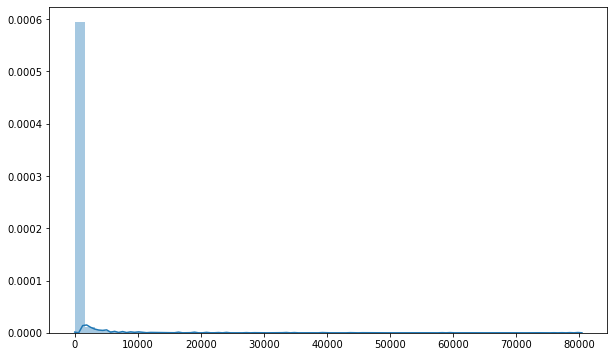

In [19]:
plt.figure(figsize=(10,6))

sns.distplot(no_of_ratings_ingredient);

In [20]:
no_of_ratings_ingredient.describe()

,no_of_ratings_ingredient
count,5570.000
mean,452.697
std,2740.982
min,1.000
25%,7.000
50%,28.500
75%,112.000
max,80390.000


We can see that there are many ingredients that have very few reviews while there is an ingredient that has 1.5M reviews. In the following graph we'll try to decide thich is the minimum reviews that an ingredient should have to continue with the model. We will try to build the model with a **min_threshold of 100** and **max_threshold of 10000**.

In [21]:
min_threshold_ingredient = 100
max_threshold_ingredient = 10000

no_of_ratings_ingredient_subset = no_of_ratings_ingredient[(no_of_ratings_ingredient['no_of_ratings_ingredient'] > min_threshold_ingredient) & (no_of_ratings_ingredient['no_of_ratings_ingredient'] < max_threshold_ingredient)]

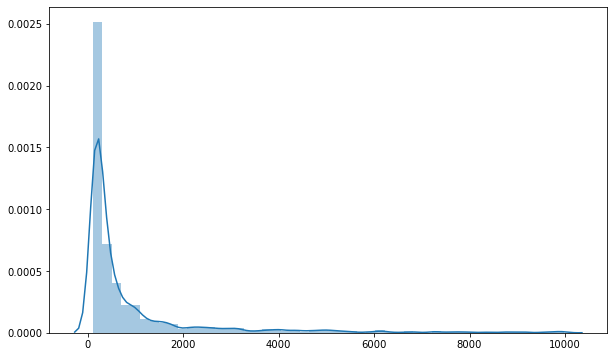

In [22]:
plt.figure(figsize=(10,6))

sns.distplot(no_of_ratings_ingredient_subset);

In [23]:
no_of_ratings_ingredient_subset.shape

(1420, 1)

In [24]:
print(f'We are goin to carry on with our model with {no_of_ratings_ingredient_subset.shape[0]} ingredients')

We are goin to carry on with our model with 1420 ingredients


### 2.2 Filter users with almost no ratings.

1. Count ratings per each user_id
2. Fitler

#### 2..2.1 Counting ratings per each user_id
We are going to identify which are the users that does not have enough ratings to be meaningful for our model

In [25]:
no_of_ratings_user = (subset
                      .groupby("user_id", as_index=True)
                      .agg({"rating": "count"})
                      .rename(columns={"rating": "no_of_ratings_user"}))

In [26]:
no_of_ratings_user.head()

,no_of_ratings_user
user_id,
32,27
39,228
64,22
71,58
81,13


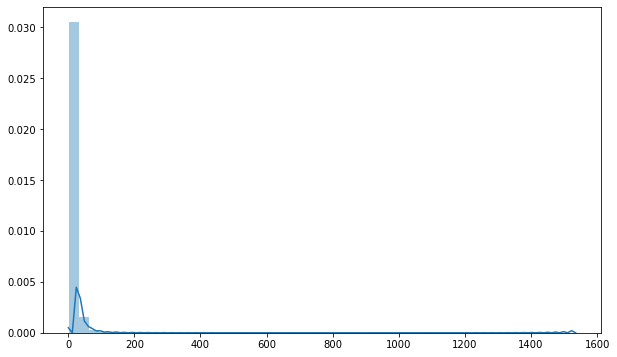

In [27]:
plt.figure(figsize=(10,6))

sns.distplot(no_of_ratings_user);

In [28]:
no_of_ratings_user.describe()

,no_of_ratings_user
count,164044.000
mean,15.371
std,22.397
min,2.000
25%,8.000
50%,11.000
75%,16.000
max,1533.000


We can see that there are some users that have very few ratings while there are others with 295. In the following graph we'll try to decide thich is the minimum ratings that a user should have done in order to continue with the model. We will try to build the model with a **min_threshold of 10** and a **max_threshold of 1000**.

### 2.2.2 Filter

In [29]:
min_threshold_user = 10
max_threshold_user = 1000

no_of_ratings_user_subset = no_of_ratings_user[(no_of_ratings_user['no_of_ratings_user'] > min_threshold_user) & (no_of_ratings_user['no_of_ratings_user'] < max_threshold_user)]

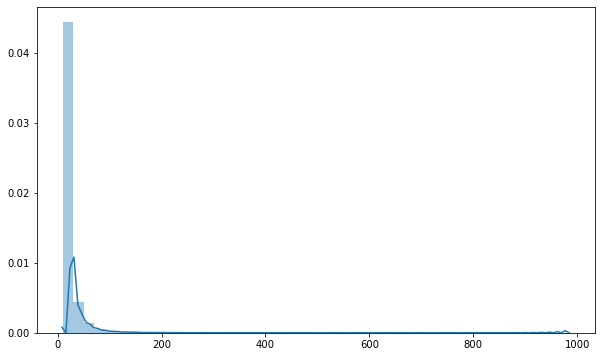

In [30]:
plt.figure(figsize=(10,6))

sns.distplot(no_of_ratings_user_subset);

In [31]:
print(f'We are goin to carry on with our model with {no_of_ratings_user_subset.shape[0]} users')

We are goin to carry on with our model with 87838 users


### 3.2 Prepare the subset for the model
Now that we know with the ingredients and the users that we will keep for the model, we can prepare the dataset for the model. 

In [32]:
# Group subset by ingredient and avegage in case that a user rated an ingredient more than once
# subset = subset.groupby('ingredients').agg({'mean'})
# subset.reset_index(inplace=True)

In [33]:
subset.head()

,user_id,rating,ingredients
0,8542392,5,pork belly
0,8542392,5,smoked paprika
0,8542392,5,kosher salt
0,8542392,5,ground black pepper
1,11174581,5,pork belly


In [34]:
# Merge with number of ratings
subset_ml = (subset
             .merge(no_of_ratings_ingredient, how='left', on='ingredients')
             .merge(no_of_ratings_user, how='left', on='user_id'))

subset_ml.reset_index(drop=True, inplace=True)

In [35]:
subset_ml.head()

,user_id,rating,ingredients,no_of_ratings_ingredient,no_of_ratings_user
0,8542392,5,pork belly,9,11
1,8542392,5,smoked paprika,324,11
2,8542392,5,kosher salt,3685,11
3,8542392,5,ground black pepper,45869,11
4,11174581,5,pork belly,9,4


In [36]:
# Drop ingredients with less than min_threshold_ingredient
final_ingredients = subset_ml[(subset_ml['no_of_ratings_ingredient'] >= min_threshold_ingredient) &
                              (subset_ml['no_of_ratings_ingredient'] <= max_threshold_ingredient)]

# Drop users with less than the min_threshols_user
final_ingredients = final_ingredients[(final_ingredients['no_of_ratings_user'] >= min_threshold_user) &
                                      (final_ingredients['no_of_ratings_user'] >= min_threshold_user)]

# Reset index
final_ingredients.reset_index(drop=True, inplace=True)

In [37]:
final_ingredients.shape

(1073218, 5)

In [38]:
final_ingredients.head()

,user_id,rating,ingredients,no_of_ratings_ingredient,no_of_ratings_user
0,8542392,5,smoked paprika,324,11
1,8542392,5,kosher salt,3685,11
2,3574785,5,sauerkraut drained,169,21
3,3574785,5,large onion,5439,21
4,3574785,5,caraway seeds,476,21


### 2.3 Create feature set


In [39]:
# Pivot tables
ingredient_features = final_ingredients.pivot_table(index="ingredients",
                                          columns="user_id",
                                          values="rating").fillna(0)

In [40]:
print(f"Number of users: {ingredient_features.shape[0]}")
print(f"Number of ingredients: {ingredient_features.shape[1]}")

Number of users: 1433
Number of ingredients: 103492


In [41]:
ingredient_features.head(10)

user_id,32,39,64,71,81,103,138,208,213,240,...,23368068,23370390,23370403,23374791,23375614,23384606,23389673,23397702,23412582,23417930
ingredients,,,,,,,,,,,,,,,,,,,,,
,0.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Alfredo sauce,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
American cheese,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
American processed cheese,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Asian (toasted) sesame oil,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Asian chile paste,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Asian chile pepper sauce,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Asian fish sauce,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Bavarian-style sauerkraut undrained,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## 3. Modelling
### 3.1 Unsupervised ML model 1.0

This model will take as an input and ingredient and return a list of 10 ingredients that users from allrecipes have also rated positively. 

In [42]:
from scipy.sparse import csr_matrix

In [43]:
mat_ingredient_features = csr_matrix(ingredient_features)

#### 3.1.1 Train KNN (K-Nearest-Neighbors)

In [44]:
from sklearn.neighbors import NearestNeighbors

In [45]:
model_knn = NearestNeighbors(metric="cosine",
                             algorithm="brute",
                             n_jobs=-1)

model_knn.fit(mat_ingredient_features)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=5, p=2, radius=1.0)

In [46]:
# In order to be able to start the program from here, I can export and import as a pickle
#with open("final-project/model_knn.pkl", "wb") as mk:
#    pickle.dump(model_knn, mk, protocol=pickle.HIGHEST_PROTOCOL)

In [47]:
ingredient_features.head()

user_id,32,39,64,71,81,103,138,208,213,240,...,23368068,23370390,23370403,23374791,23375614,23384606,23389673,23397702,23412582,23417930
ingredients,,,,,,,,,,,,,,,,,,,,,
,0.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Alfredo sauce,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
American cheese,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
American processed cheese,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Asian (toasted) sesame oil,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [48]:
ingredient_features.loc['Alfredo sauce'].values.reshape(1, -1)

array([[0., 0., 0., ..., 0., 0., 0.]])

In [49]:
input_ = 'Alfredo sauce'

In [50]:
model_knn.kneighbors(ingredient_features.loc[input_].values.reshape(1, -1), n_neighbors=5)
# print(f'Array with the distance of the ingredients: {model_knn.kneighbors(ingredient_features.loc['Dijon mustard'].values.reshape(1, -1), n_neighbors=5)[0]}')
# print(f'Array with the id of the ingredients: {model_knn.kneighbors(ingredient_features.loc['Dijon mustard'].values.reshape(1, -1), n_neighbors=5)[1]}')

(array([[0.        , 0.07356679, 0.07356679, 0.11679654, 0.21458574]]),
 array([[   1, 1009,  617,  203, 1187]]))

Our kNN model returns a tuple of two 2d-arrays, containing distances and indeces of the nearest neighbors of the vector passed. In order for us to match the results with 'ingredients', we need to translate the output.

In [51]:
result = model_knn.kneighbors(ingredient_features.loc[input_].values.reshape(1, -1), n_neighbors=10)

In [52]:
result[1][0][2]

1009

In [53]:
ingredient_features.iloc[result[1][0][2]].name

'pesto sauce'

In [54]:
print(f'If you are buying {input_} you may also want to buy:')
print(f'---------------------------------------------------------')

print(f'1. {ingredient_features.iloc[result[1][0][0]].name}')
print(f'2. {ingredient_features.iloc[result[1][0][1]].name}')
print(f'3. {ingredient_features.iloc[result[1][0][2]].name}')
print(f'4. {ingredient_features.iloc[result[1][0][3]].name}')
print(f'5. {ingredient_features.iloc[result[1][0][4]].name}')
print(f'5. {ingredient_features.iloc[result[1][0][5]].name}')
print(f'5. {ingredient_features.iloc[result[1][0][6]].name}')
print(f'5. {ingredient_features.iloc[result[1][0][7]].name}')
print(f'5. {ingredient_features.iloc[result[1][0][8]].name}')
print(f'5. {ingredient_features.iloc[result[1][0][9]].name}')

If you are buying Alfredo sauce you may also want to buy:
---------------------------------------------------------
1. Alfredo sauce
2. fresh baby spinach
3. pesto sauce
4. box penne pasta
5. shredded Italian cheese blend
5. cubed cooked chicken
5. seasoned bread crumbs
5. crushed tomatoes
5. ricotta cheese
5. frozen chopped spinach thawed and drained


The model works with 1 ingredient as an input, however, we would like to be able to give multiple ingredients as arguments. To do so, we are going to try to create a numpy array and pass it as the input.

### 3.2 Unsupervised ML model 2.0

This model will take as an input a LIST of ingredients and return a list of 10 ingredients that users from allrecipes have also rated positively. 

In [55]:
input_list = ['American cheese', 'Dijon mustard']
input_arr = np.array(input_list) 
input_arr

array(['American cheese', 'Dijon mustard'], dtype='<U15')

In [56]:
ingredient_features.loc[['American cheese', 'Dijon mustard']]

user_id,32,39,64,71,81,103,138,208,213,240,...,23368068,23370390,23370403,23374791,23375614,23384606,23389673,23397702,23412582,23417930
ingredients,,,,,,,,,,,,,,,,,,,,,
American cheese,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Dijon mustard,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000


In [57]:
ingredient_features.loc[['American cheese', 'Dijon mustard']].values

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [58]:
ingredient_features.loc[['American cheese', 'Dijon mustard']].values#.reshape(1, -1)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

#### 3.2.1 Finding top 10 recommendations
In order to find the closest recommendations od a list of ingredients we are going to create a dataframe that will look like the following: 

|Ingredient Position|Distance|
|----|----|
|202|0.84|
|...|...|

We will append the output from the KNN model for each ingredient and then group them by ingredient to obtain the mean 'Distance'. With that we will be able to sort by distance in a Descending order and obtain the Top10 recommended ingredients.

In [59]:
model_knn.kneighbors(ingredient_features.loc[input_arr].values, n_neighbors=10)


(array([[1.99840144e-15, 2.25790865e-01, 7.49995974e-01, 7.55860109e-01,
         8.37839117e-01, 8.39149553e-01, 8.88327262e-01, 8.98369153e-01,
         9.15283200e-01, 9.34938906e-01],
        [2.10942375e-14, 6.76817516e-01, 6.76817516e-01, 6.79227439e-01,
         6.83023355e-01, 6.91743388e-01, 6.93344566e-01, 6.95367944e-01,
         7.00201186e-01, 7.06279795e-01]]),
 array([[   2,  970,   43, 1320, 1029,  899,  807, 1352, 1058, 1201],
        [  26, 1428, 1304,  489,  966, 1177,  569,  571, 1041,  244]]))

In [60]:
ingredient_features.iloc[180].name

'boneless pork loin'

In [61]:
knn = model_knn.kneighbors(ingredient_features.loc[input_arr].values, n_neighbors=10)

In [62]:
# Zip the ingredients position with the distance to the input 'ingredient'
z = zip(knn[1][0].tolist(), knn[0][0].tolist())

In [63]:
# Formate it as a list
z_list = [(x, y) for x, y in z]

z_list

# I have to drop the first row

[(2, 1.9984014443252818e-15),
 (970, 0.22579086470607346),
 (43, 0.749995974041373),
 (1320, 0.7558601088833039),
 (1029, 0.837839117337836),
 (899, 0.8391495527857413),
 (807, 0.8883272615441179),
 (1352, 0.8983691529632095),
 (1058, 0.9152831997235281),
 (1201, 0.9349389061518224)]

In [64]:
model = pd.DataFrame(z_list, columns=('Ingredient Position', 'Distance'))

In [65]:
model

,Ingredient Position,Distance
0,2,0.000
1,970,0.226
2,43,0.750
3,1320,0.756
4,1029,0.838
5,899,0.839
6,807,0.888
7,1352,0.898
8,1058,0.915
9,1201,0.935


In [66]:
model = model.drop(model[model['Distance'] == 0].index).reset_index(drop=True)

In [67]:
model

,Ingredient Position,Distance
0,2,0.000
1,970,0.226
2,43,0.750
3,1320,0.756
4,1029,0.838
5,899,0.839
6,807,0.888
7,1352,0.898
8,1058,0.915
9,1201,0.935


Once understood how to create the DataFrame that we are looking for, lets create a for loop that creates it for the whole list of ingredients

In [68]:
def get_top10_recommendations(ingredients:list):

    input_arr = np.array(ingredients)
    
    # Create empty DataFrame
    model = pd.DataFrame(columns=('Ingredient Position', 'Distance'))
    
    # Generate the model
    knn = model_knn.kneighbors(ingredient_features.loc[input_arr].values, n_neighbors=10)
    
    for i, ing in enumerate(ingredients):
        
        # Zip the ingredients position with the distance to the input 'ingredient'
        z = zip(knn[1][i].tolist(), knn[0][i].tolist())
        
        # Formate it as a list
        z_list = [(x, y) for x, y in z]
    
        # Create the DataFrame
        temp = pd.DataFrame(z_list, columns=('Ingredient Position', 'Distance'))
        
        # Drop the rows of the ingredients that are already in our list
        temp = temp.drop(temp[temp['Distance'] <= 0.001].index)

        # Concat the new list of (Position, Distance) with the final df
        model = pd.concat([model, temp])
        
    # Group by ingredient position and sort by distance
    model = model.groupby('Ingredient Position').agg({'Distance': 'mean'})
    model = model.sort_values(by='Distance', ascending=True).reset_index()
    
    # Print output header
    print(f'If you are buying {ingredients} you may also want to buy:')
    print(f'---------------------------------------------------------\n')
    
    for x in range(0, 10):
        # Print a list with the top 10 recommendations
        print(f'{x + 1}.{ingredient_features.iloc[model["Ingredient Position"][x]].name}')
    
    return model.head(10)
        

In [74]:
get_top10_recommendations(['American cheese', 'Dijon mustard'])

If you are buying ['American cheese', 'Dijon mustard'] you may also want to buy:
---------------------------------------------------------

1.onion rolls
2.sun-dried tomatoes chopped
3.zucchini cut in half lengthwise then sliced diagonally
4.dill weed
5.oil
6.shallots minced
7.fat-free chicken broth
8.fat-free sour cream
9.pork tenderloins
10.cayenne pepper to taste (optional)


,Ingredient Position,Distance
0,970,0.226
1,1304,0.677
2,1428,0.677
3,489,0.679
4,966,0.683
5,1177,0.692
6,569,0.693
7,571,0.695
8,1041,0.700
9,244,0.706


Now we are able to recomend which are, on average, the ingredients that people that have rated the ingredients that we are giving as an input are also rating positively. 

To make it more user friendly, we will add the fuzzy wuzzy package

### 3.3 Unsupervised ML model 3.0

This model will take as an input a LIST of ingredients (without the necessity of being exactly as the ing on the database) and return a list of 10 ingredients that users from allrecipes have also rated positively. 

#### 3.3.1 Introducing fuzzywuzzy

In [75]:
# Add the packages
from fuzzywuzzy import fuzz

In [76]:
fuzz.ratio("Coca Cola", "Coca Cola")

100

In [77]:
input_ing = "pasta"

In [78]:
final_ingredients['ingredients'].value_counts()

peeled and diced potatoes                9938
diced cooked ham                         9903
ground white                             9829
chili beans                              9618
tomato paste                             9078
                                         ... 
pineapple chunks with juice                40
Hellmann's® Real Mayonnaise                40
Salt and ground black pepper to taste      34
margarine melted                           29
hot pork sausage                           27
Name: ingredients, Length: 1433, dtype: int64

In [79]:
# get unique list of ingredients that are being used for the model
unique_ingredients = final_ingredients['ingredients'].unique().tolist()

In [80]:
# Double check if it is the same number as before
len(unique_ingredients)

1433

In [81]:
matches = []

for ing in unique_ingredients:
    ratio = fuzz.ratio(ing.lower(), input_ing.lower())

    if ratio > 60:
        matches.append((ing, ratio))
        
matches = sorted(matches, key=lambda x: x[1], reverse=True)

In [82]:
matches

[('orzo pasta', 67),
 ('peas', 67),
 ('pasta sauce', 62),
 ('penne pasta', 62),
 ('pancetta', 62)]

In [83]:
# Add the best match to a list
clean_list = []

clean_list.append(matches[0][0])

In [84]:
clean_list

['orzo pasta']

#### 3.3.2 Appling fuzzywuzzy to the model

In [85]:
def get_translation(ingredients:list):
    
    clean_list = []
    
    # ...
    for ingredient in ingredients:

        matches = []

        for ing in unique_ingredients:
            ratio = fuzz.ratio(ing.lower(), ingredient.lower())

            if ratio > 50:
                matches.append((ing, ratio))
                matches = sorted(matches, key=lambda x: x[1], reverse=True)
                
        if matches:
            clean_list.append(matches[0][0])
        else: 
            clean_list.append(np.nan)
            
    return clean_list

In [86]:
get_translation(['Cheese', 'Mustard', 'Parmesan cheese'])

['blue cheese', 'dry mustard', 'Parmesan cheese']

Maybe we can try to add more than 437 ingredients. Or at least be able to understand why there is no rice

In [87]:
# Add fuzzy function
def get_top10_recommendations(ingredients:list):
    
    ingredients = get_translation(ingredients)
    
    input_arr = np.array(ingredients)
    
    # Create empty DataFrame
    model = pd.DataFrame(columns=('Ingredient Position', 'Distance'))
    
    # Generate the model
    knn = model_knn.kneighbors(ingredient_features.loc[input_arr].values, n_neighbors=10)
    
    for i, ing in enumerate(ingredients):
        
        # Zip the ingredients position with the distance to the input 'ingredient'
        z = zip(knn[1][i].tolist(), knn[0][i].tolist())
        
        # Formate it as a list
        z_list = [(x, y) for x, y in z]
    
        # Create the DataFrame
        temp = pd.DataFrame(z_list, columns=('Ingredient Position', 'Distance'))
        
        # Drop the rows of the ingredients that are already in our list
        temp = temp.drop(temp[temp['Distance'] <= 0.001].index)

        # Concat the new list of (Position, Distance) with the final df
        model = pd.concat([model, temp])
        
    # Group by ingredient position and sort by distance
    model = model.groupby('Ingredient Position').agg({'Distance': 'mean'})
    model = model.sort_values(by='Distance', ascending=True).reset_index()
    
    # Print output header
    print(f'If you are buying {ingredients} you may also want to buy:')
    print(f'---------------------------------------------------------\n')
    
    for x in range(0, 10):
        # Print a list with the top 10 recommendations
        print(f'{x + 1}.{ingredient_features.iloc[model["Ingredient Position"][x]].name}')
    
    return model.head(10)
        

In [94]:
get_top10_recommendations(['Cheese', 'Red wine', 'chestnut', 'Mustard', 'Parmesan cheese', 'Rice', 'noodles', 'pasta', 'mushrooms'])

If you are buying ['blue cheese', 'red wine', 'water chestnuts', 'dry mustard', 'Parmesan cheese', 'rice wine', 'egg noodles', 'orzo pasta', 'fresh mushrooms'] you may also want to buy:
---------------------------------------------------------

1.fresh mushrooms finely diced
2.finely diced smoked ham
3.unbaked pie crusts
4.frozen chopped spinach thawed
5.thick sliced bacon
6.snow peas
7.sliced carrots
8.beef round steak
9.vegetable broth
10.chopped cooked chicken breast


,Ingredient Position,Distance
0,636,0.094
1,592,0.094
2,1365,0.097
3,659,0.098
4,1324,0.133
5,1272,0.167
6,1227,0.168
7,136,0.184
8,1387,0.222
9,283,0.237
